# 6 Inference on CPU

### 1. Import dependencies

In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm.notebook import trange, tqdm
from PIL import Image
import tarfile
import os.path
import sagemaker

In [3]:
import datetime
currentDT = datetime.datetime.now()
print (str(currentDT))

2020-05-20 11:59:19.768442


In [4]:
torch.__version__

'1.4.0'

### 2. Create PyTorch data generators

In [5]:
# handler to sagemaker session object
session = sagemaker.Session()

# pull source_data_2.tar.gz from S3
prefix = 'road-signs-classifier'
bucket = 'sagemaker-us-east-1-731572931236'
session.download_data(path='downloads', bucket=bucket, key_prefix=prefix)

In [6]:
def extract_tar_gz(filename, destination_dir):
    with tarfile.open(filename, 'r:gz') as _tar:
        _tar.extractall(destination_dir)

def make_tar_gz(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))

def make_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
        
def rm_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


make_dir('./test')
extract_tar_gz('./downloads/source_data_2.tar.gz', './test')

In [7]:
#os.rmdir('./test')

In [8]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

In [10]:
# define dataloader parameters
batch_size = 64
num_workers_test = 4

normalize = transforms.Normalize(mean=[0.5],
                                 std=[0.5])

data_transform_test = transforms.Compose([
        transforms.Resize((32,32)),
        transforms.Grayscale(1),
        transforms.ToTensor(),
        normalize
])

test_dataset = datasets.ImageFolder('./source_data_2/test/', data_transform_test)
c = torch.utils.data.DataLoader(test_dataset,
                                batch_size=batch_size,
                                shuffle=False, num_workers=num_workers_test)
test_dataloader =WrappedDataLoader(c, to_device)

### 3. Create the network

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
class Stn(nn.Module):
    def __init__(self):
        super(Stn, self).__init__()
        # Spatial transformer localization-network
        self.loc_net = nn.Sequential(
            nn.Conv2d(1, 50, 7),
            nn.MaxPool2d(2, 2),
            nn.ELU(),
            nn.Conv2d(50, 100, 5),
            nn.MaxPool2d(2, 2),
            nn.ELU()
        )
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(100 * 4 * 4, 100),
            nn.ELU(),
            nn.Linear(100, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def forward(self, x):
        xs = self.loc_net(x)
        xs = xs.view(-1, 100 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

In [13]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        #input_chan = 1 if gray else 3
        self.stn = Stn()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.stn(x)
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x
model = BaselineNet(gray=True).to(device)

In [14]:
print(model)

BaselineNet(
  (stn): Stn(
    (loc_net): Sequential(
      (0): Conv2d(1, 50, kernel_size=(7, 7), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ELU(alpha=1.0)
      (3): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ELU(alpha=1.0)
    )
    (fc_loc): Sequential(
      (0): Linear(in_features=1600, out_features=100, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=100, out_features=6, bias=True)
    )
  )
  (conv1): Conv2d(1, 100, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con

In [17]:
model.load_state_dict(torch.load('./model/model.pre-trained_5', map_location=torch.device('cpu')))

<All keys matched successfully>

In [18]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)


In [19]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)



In [26]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accuracy: {test_accuracy:.3f}%")

In [21]:
n_classes = 43
def create_confusion_matrix(model, dl):
    model.eval()
    all_preds = torch.tensor([], dtype=torch.long).to(device)
    all_labels = torch.tensor([], dtype=torch.long).to(device)
    with torch.no_grad():
        for batch in dl:
            images, labels = batch
            images = images.to(device)
            preds_all_classes = model(images)
            preds =  torch.argmax(preds_all_classes, 1) # get top class
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
    conf_matrix = torch.zeros(n_classes, n_classes)
    for t, p in zip(all_labels.cpu().numpy(), all_preds.cpu().numpy()):
        conf_matrix[t, p] += 1
    conf_matrix = np.asarray(conf_matrix.numpy().astype(int))
    return conf_matrix

conf_matrix = create_confusion_matrix(model, test_dataloader)
conf_matrix

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


array([[ 60,   0,   0, ...,   0,   0,   0],
       [  0, 720,   0, ...,   0,   0,   0],
       [  0,   2, 746, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  88,   0,   0],
       [  0,   0,   0, ...,   0,  60,   0],
       [  0,   0,   0, ...,   2,   0,  88]])

In [22]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, zero_diagonal=False):
    if zero_diagonal:
        cm = np.copy(cm)
        np.fill_diagonal(cm, 0)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 60   0   0 ...   0   0   0]
 [  0 720   0 ...   0   0   0]
 [  0   2 746 ...   0   0   0]
 ...
 [  0   0   0 ...  88   0   0]
 [  0   0   0 ...   0  60   0]
 [  0   0   0 ...   2   0  88]]


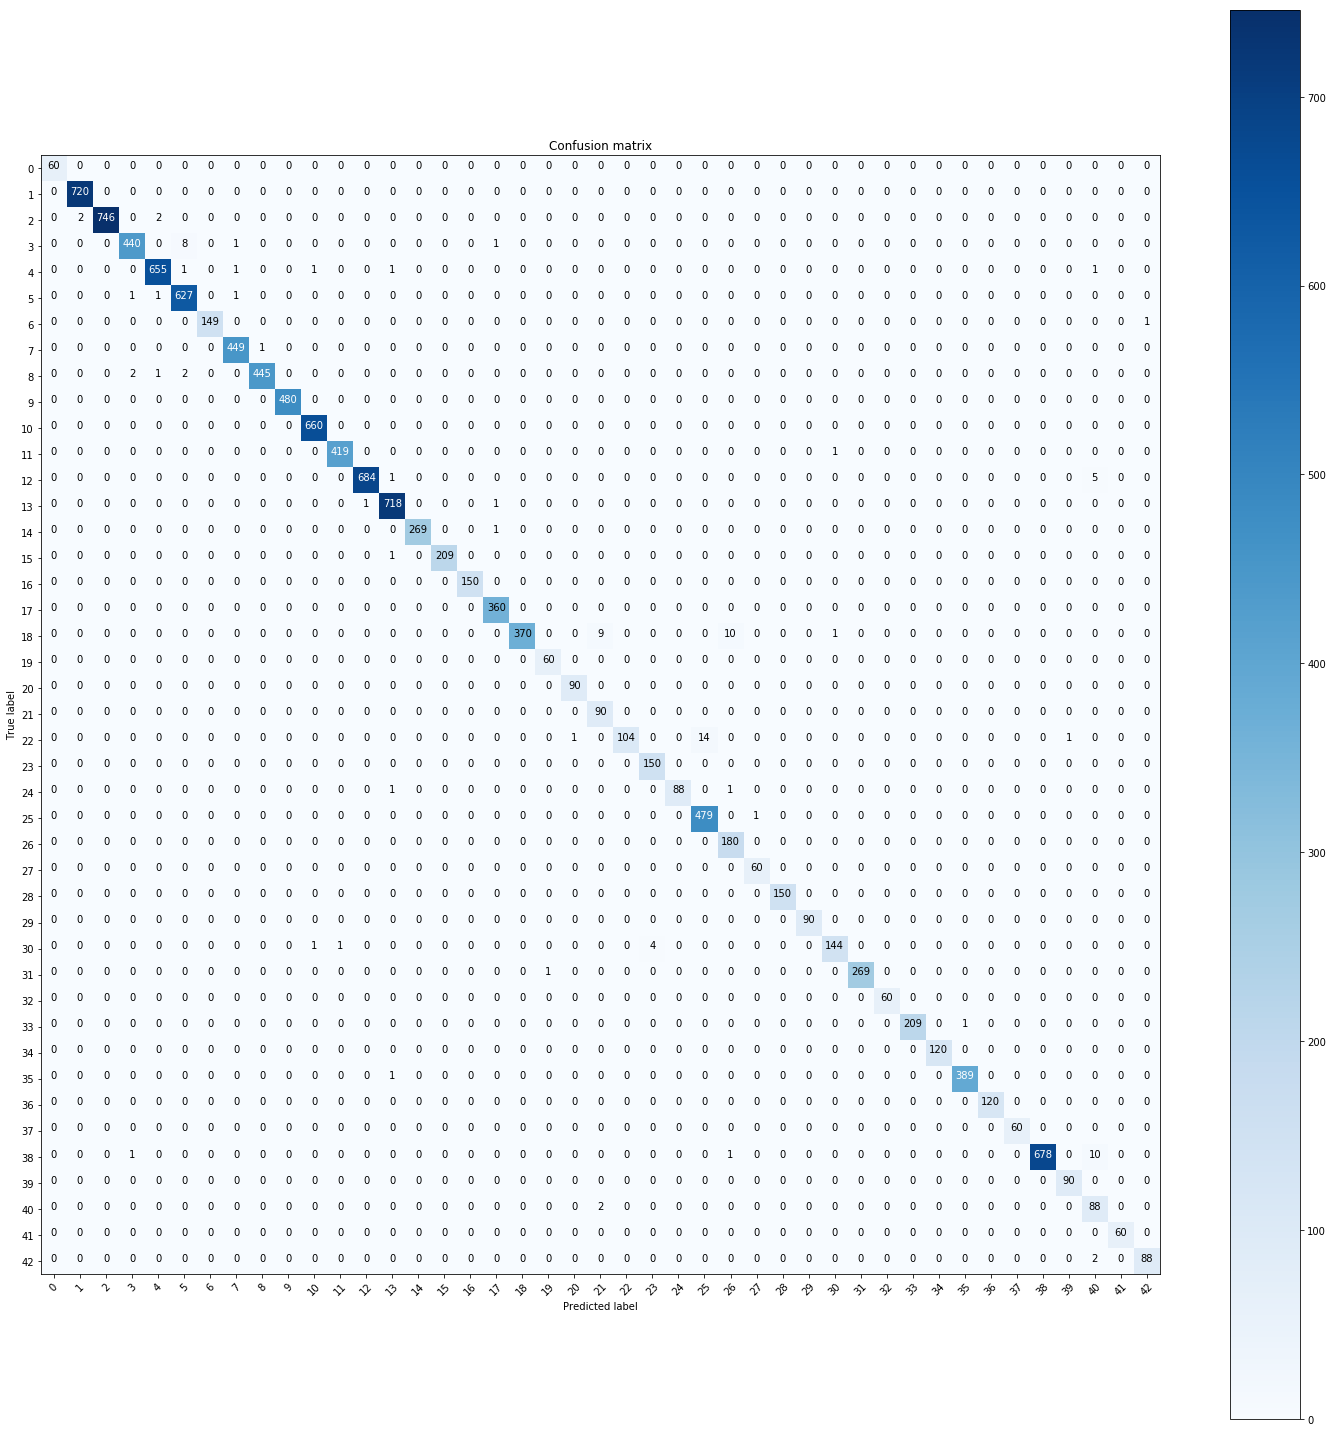

In [179]:
#np.fill_diagonal(conf_matrix, 0)
plot_confusion_matrix(conf_matrix, range(43), zero_diagonal=False)

Confusion matrix, without normalization
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 2 0 0]]


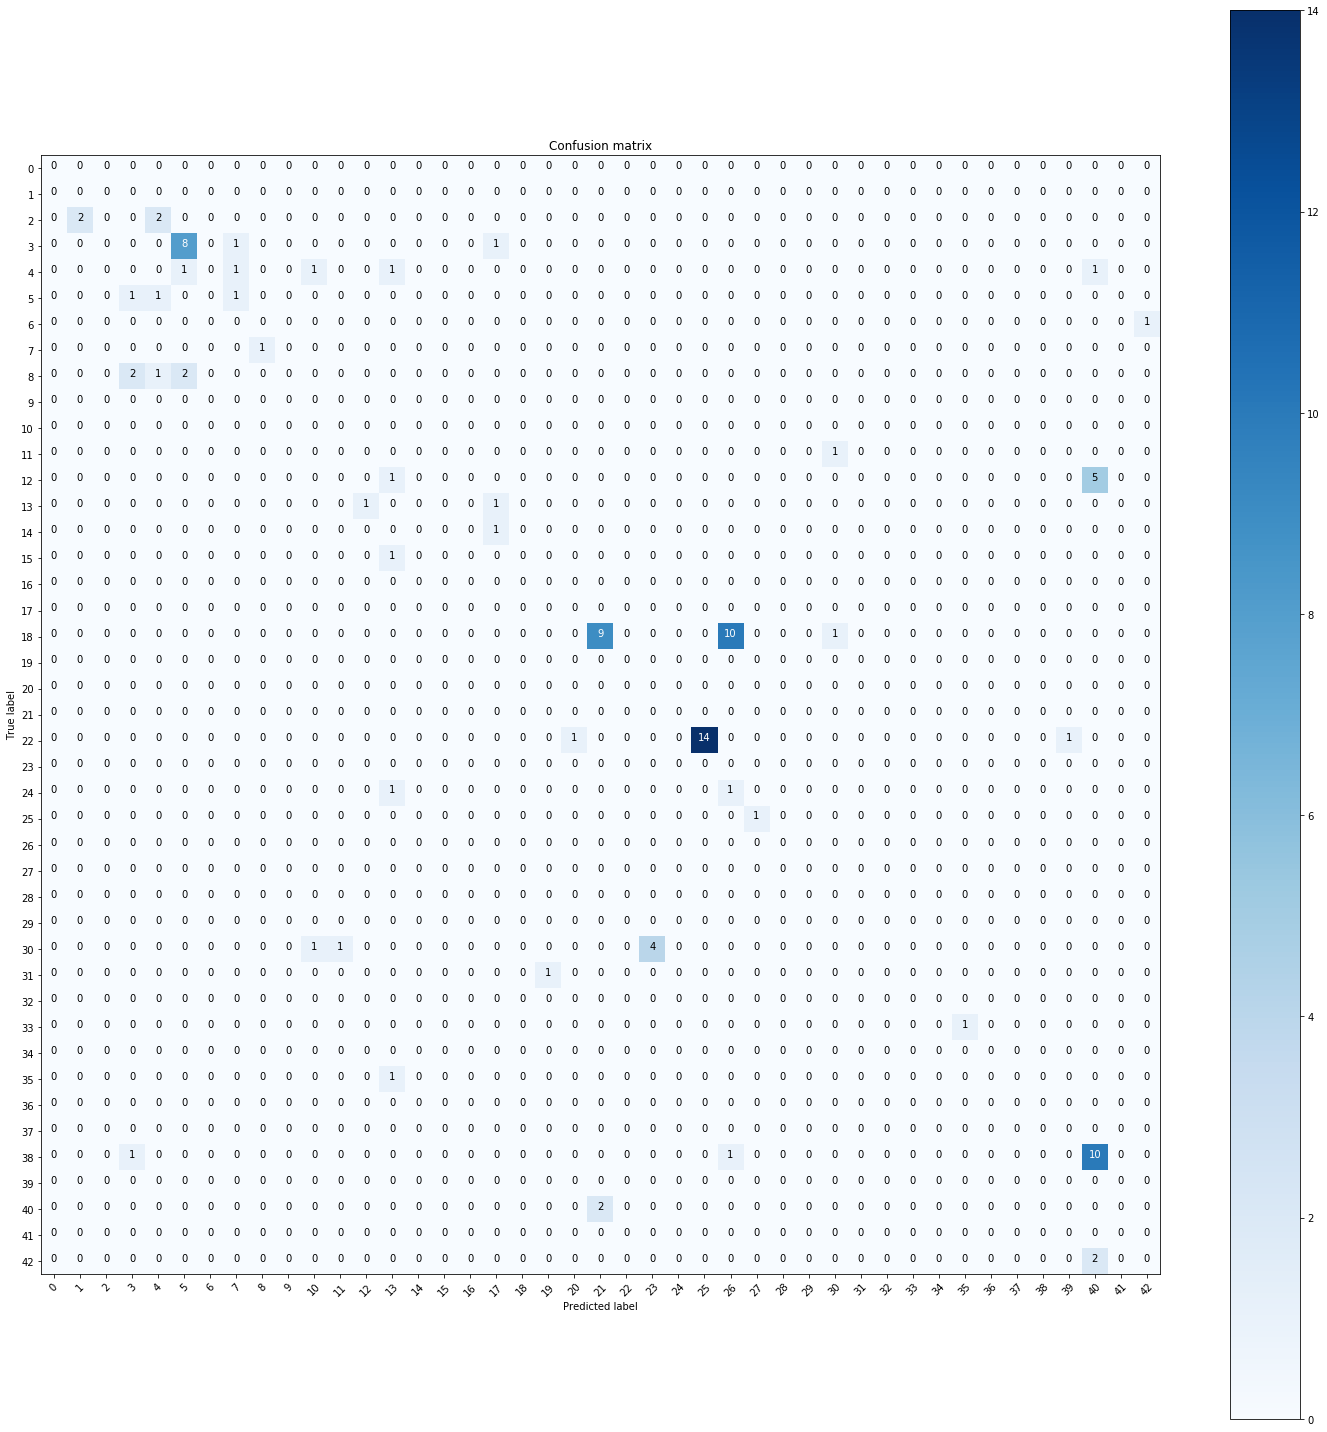

In [23]:
np.fill_diagonal(conf_matrix, 0)
plot_confusion_matrix(conf_matrix, range(43), zero_diagonal=False)

In [24]:
def take_third(elem):
    return elem[2]

def get_top_conf(conf_matrix, min_val = 3):
    np.fill_diagonal(conf_matrix, 0)
    classes = range(43)
    res = [(classes[i],classes[j],conf_matrix[i,j])
                    for i,j in zip(*np.where(conf_matrix>=min_val))]
    return sorted(res, key=take_third, reverse=True)

print(get_top_conf(conf_matrix))

[(22, 25, 14), (18, 26, 10), (38, 40, 10), (18, 21, 9), (3, 5, 8), (12, 40, 5), (30, 23, 4)]


In [27]:
%%time
criterion = nn.CrossEntropyLoss()
evaluate(model, criterion, test_dataloader)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Test loss: 0.029522	Test accuracy: 99.177%
CPU times: user 1min 11s, sys: 1.26 s, total: 1min 12s
Wall time: 40.5 s


### 6. Make predictions on sample test images¶

In [16]:
validation_img_paths = ["./source_data_2/test/00/00243.ppm",
                        "./source_data_2/test/01/00001.ppm",
                        "./source_data_2/test/02/00034.ppm"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]
validation_classes = [0, 1, 2]

In [18]:
validation_batch = torch.stack([data_transform_test(img).to(device)
                                for img in img_list])

In [19]:
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


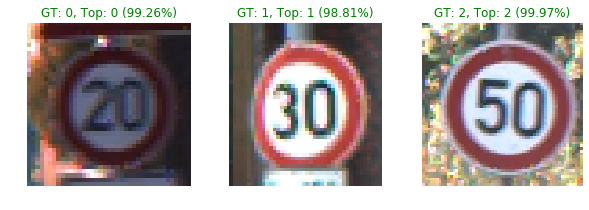

In [20]:
fig, axs = plt.subplots(1, len(img_list), figsize=(10, 3))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    maxConfidenceValue = np.amax(pred_probs[i,:])
    maxConfidenceClass = np.where(pred_probs[i,:] == maxConfidenceValue)[0][0]
    color = 'green'
    if maxConfidenceClass != validation_classes[i]:
        color = 'red'
    ax.set_title("GT: {}, Top: {} ({:.2f}%)".format(validation_classes[i], maxConfidenceClass, maxConfidenceValue*100), color=color)
    ax.imshow(img)

### 7. Measure evaluation time on CPU

In [31]:
%%time

validation_img_paths = ["./source_data_2/test/00/00243.ppm"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]
validation_classes = [0]
for i in range(1000):
    validation_batch = torch.stack([data_transform_test(img).to(device)
                                    for img in img_list])
    pred_logits_tensor = model(validation_batch)
    pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


CPU times: user 11 s, sys: 203 ms, total: 11.2 s
Wall time: 5.63 s


In [21]:
currentDT = datetime.datetime.now()
print (str(currentDT))

2020-05-04 20:11:52.289151
